# Lecture 32: Residuals

In [1]:
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

## Non-linear regression

In [2]:
hybrid = Table.read_table('hybrid.csv')
hybrid

vehicle,year,msrp,acceleration,mpg,class
Prius (1st Gen),1997,24509.7,7.46,41.26,Compact
Tino,2000,35355,8.2,54.1,Compact
Prius (2nd Gen),2000,26832.2,7.97,45.23,Compact
Insight,2000,18936.4,9.52,53,Two Seater
Civic (1st Gen),2001,25833.4,7.04,47.04,Compact
Insight,2001,19036.7,9.52,53,Two Seater
Insight,2002,19137,9.71,53,Two Seater
Alphard,2003,38084.8,8.33,40.46,Minivan
Insight,2003,19137,9.52,53,Two Seater
Civic,2003,14071.9,8.62,41,Compact


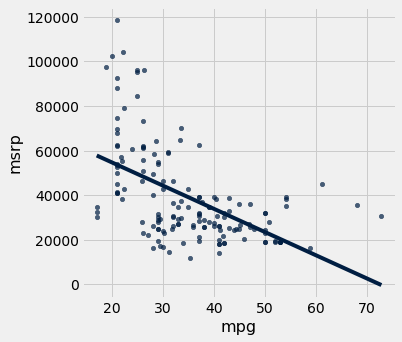

In [3]:
msrp_mpg = hybrid.select('mpg', 'msrp')
msrp_mpg.scatter('mpg', fit_line=True)

**Q:** Does linear regression look appropriate?

A.  Yes  
B.  No  
C.  I don't know  

In [4]:
def msrp_mpg_linear_rmse(any_slope, any_intercept):
    x = msrp_mpg.column('mpg')
    y = msrp_mpg.column('msrp')
    predicted = any_slope*x + any_intercept
    return np.sqrt(np.mean((y - predicted) ** 2))

In [5]:
best_linear = minimize(msrp_mpg_linear_rmse)
best_linear

array([-1038.2590143 , 75448.18424053])

In [6]:
msrp_mpg_linear_rmse(best_linear.item(0), best_linear.item(1))

18081.173901346196

In [7]:
def msrp_mpg_quadratic_mse(a, b, c):
    x = msrp_mpg.column('mpg')
    y = msrp_mpg.column('msrp')
    predicted = a*(x**2) + b*x + c
    return np.sqrt(np.mean((y - predicted) ** 2))

In [8]:
best_quadratic = minimize(msrp_mpg_quadratic_mse)
best_quadratic

array([ 4.16783667e+01, -4.23934112e+03,  1.31385802e+05])

In [9]:
msrp_mpg_quadratic_mse(best_quadratic.item(0), 
                       best_quadratic.item(1), 
                       best_quadratic.item(2))

16799.565735188768

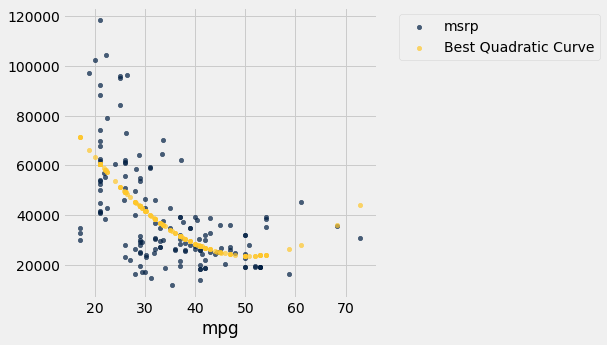

In [10]:
x = msrp_mpg.column('mpg')
quadratic_curve = best_quadratic.item(0)*(x**2) \
                  + best_quadratic.item(1)*x \
                  + best_quadratic.item(2)
msrp_mpg.with_column(
    'Best Quadratic Curve', 
    quadratic_curve
).scatter('mpg')

## Residuals

In [11]:
galton = Table.read_table('galton.csv')

heights = Table().with_columns(
    'MidParent', galton.column('midparentHeight'),
    'Child', galton.column('childHeight')
)

heights

MidParent,Child
75.43,73.2
75.43,69.2
75.43,69
75.43,69
73.66,73.5
73.66,72.5
73.66,65.5
73.66,65.5
72.06,71
72.06,68


In [12]:
def standard_units(any_numbers):
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

# t is a table; x and y are column labels

def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

def slope(t, x, y):
    r = correlation(t, x, y)
    return r * np.std(t.column(y))/np.std(t.column(x))

def intercept(t, x, y):
    a = slope(t, x, y)
    return np.mean(t.column(y)) - a * np.mean(t.column(x))

def prediction(t, x, y):
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a*t.column(x) + b

In [13]:
heights = heights.with_columns('Prediction', prediction(heights, 'MidParent', 'Child'))
heights

MidParent,Child,Prediction
75.43,73.2,70.7124
75.43,69.2,70.7124
75.43,69,70.7124
75.43,69,70.7124
73.66,73.5,69.5842
73.66,72.5,69.5842
73.66,65.5,69.5842
73.66,65.5,69.5842
72.06,71,68.5645
72.06,68,68.5645


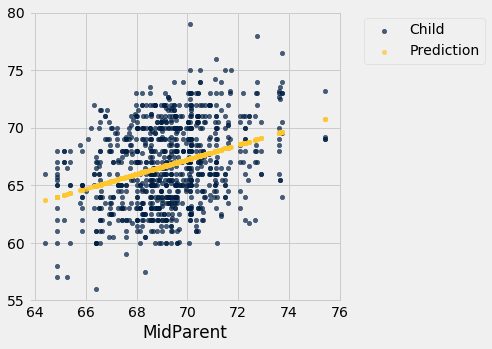

In [14]:
heights.scatter('MidParent')

**Q:** What is the minimum and maximum residual for a midparent height of about 70?

A.  min 60, max 78   
B.  min 67, max 67  
C.  min 7, max 12  
D.  min -7, max 12  

<br/><br/><br/><br/><br/><br/>

In [15]:
def residuals(t, x, y):
    return t.column(y) - prediction(t, x, y)

In [16]:
heights = heights.with_columns('Residual', residuals(heights, 'MidParent', 'Child'))
heights

MidParent,Child,Prediction,Residual
75.43,73.2,70.7124,2.48763
75.43,69.2,70.7124,-1.51237
75.43,69,70.7124,-1.71237
75.43,69,70.7124,-1.71237
73.66,73.5,69.5842,3.91576
73.66,72.5,69.5842,2.91576
73.66,65.5,69.5842,-4.08424
73.66,65.5,69.5842,-4.08424
72.06,71,68.5645,2.43553
72.06,68,68.5645,-0.564467


In [17]:
heights_residuals = heights.where('MidParent', are.between(69.5, 70.5)).sort('Residual').column('Residual')
heights_residuals.min(), heights_residuals.max()

(-7.30249220921084, 11.684760572849768)

## Residuals as regression diagnostics

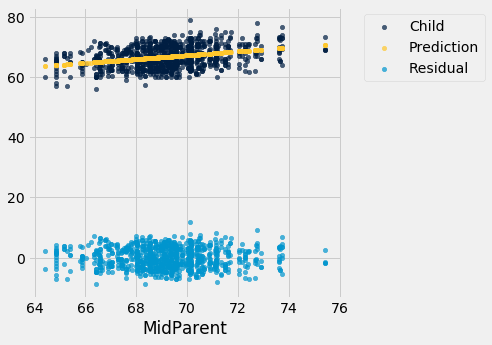

In [18]:
heights.scatter('MidParent')

In [19]:
def plot_residuals(t, x, y):
    tbl = t.with_columns(
        'Fitted', prediction(t, x, y),
        'Residual', residuals(t, x, y)
    )
    tbl.select(x, y, 'Fitted').scatter(0)
    tbl.scatter(x, 'Residual')

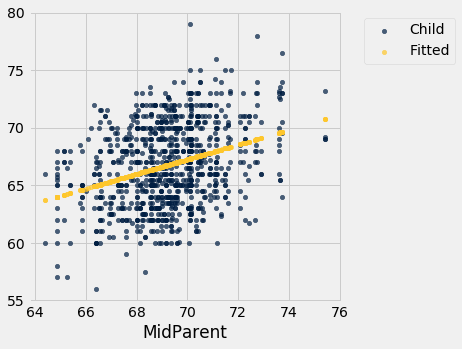

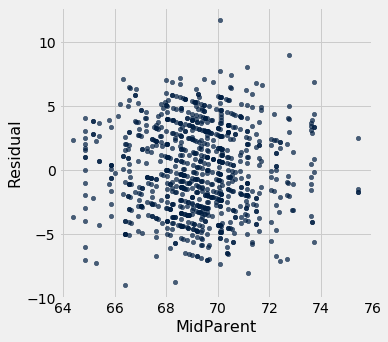

In [20]:
plot_residuals(heights, 'MidParent', 'Child')

**Q:** Do you see any pattern in the residuals?

A.  Yes  
B.  No  

<br/><br/><br/><br/>

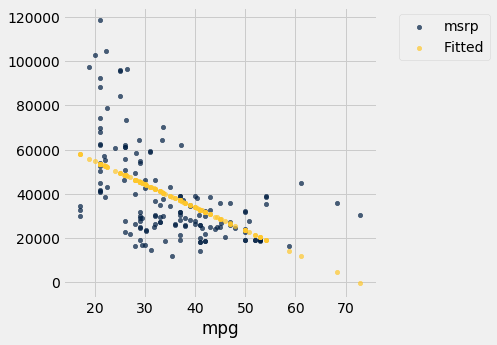

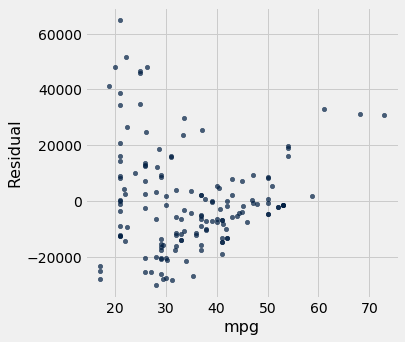

In [21]:
plot_residuals(msrp_mpg, 'mpg', 'msrp')

**Q:** Do you see any pattern in the residuals?

A.  Yes  
B.  No  

<br/><br/><br/><br/>

## Dugongs

In [22]:
# length in meters, age in years as estimated by physical characteristics such as teeth
dugong = Table.read_table('dugong.csv')
dugong

Length,Age
1.8,1
1.85,1.5
1.87,1.5
1.77,1.5
2.02,2.5
2.27,4
2.15,5
2.26,5
2.35,7
2.47,8


In [23]:
correlation(dugong, 'Length', 'Age')

0.8296474554905714

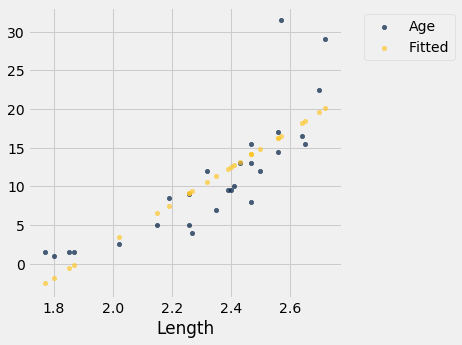

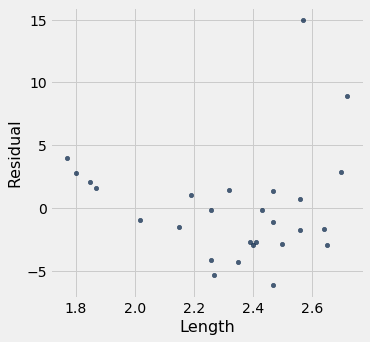

In [24]:
plot_residuals(dugong, 'Length', 'Age')

**Q:** Do you see any pattern in the residuals?

A.  Yes  
B.  No  

<br/><br/><br/><br/>

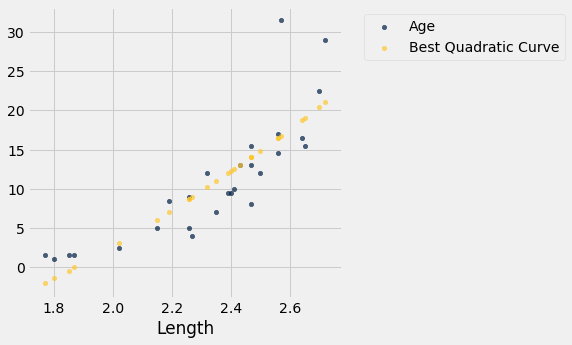

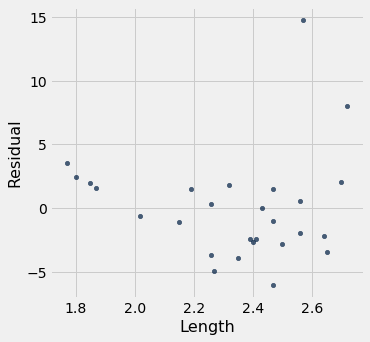

In [25]:
def dugong_quadratic_rmse(a, b, c):
    x = dugong.column('Length')
    y = dugong.column('Age')
    predicted = a*(x**2) + b*x + c
    return np.sqrt(np.mean((y - predicted) ** 2))

dugong_best_quadratic = minimize(dugong_quadratic_rmse)
x = dugong.column('Length')
dugong_quadratic_curve = dugong_best_quadratic.item(0)*(x**2) \
                  + dugong_best_quadratic.item(1)*x \
                  + dugong_best_quadratic.item(2)
dugong.with_column(
    'Best Quadratic Curve', 
    dugong_quadratic_curve
).scatter('Length')
dugong.with_column(
    'Residual', dugong.column('Age') - dugong_quadratic_curve
).scatter('Length', 'Residual')

**Q:** Do you see any pattern in the residuals?

A.  Yes  
B.  No  

<br/><br/><br/><br/>

## Mean and SD of Residuals

On average, deviation from mean (a value in the middle) is 0.

In [26]:
x = make_array(4, 8, 15, 16, 23, 42)
mean = np.mean(x)
np.mean(x - mean)

0.0

On average, deviation from prediction (a line drawn through the middle) is 0.

In [27]:
np.mean(residuals(dugong, 'Length', 'Age'))

8.15808326243078e-15

In [28]:
np.mean(residuals(heights, 'MidParent', 'Child'))

5.256799040794746e-15

In [29]:
np.mean(residuals(msrp_mpg, 'mpg', 'msrp'))

1.9022111409629872e-13

No matter what the shape of the scatter plot, the SD of the residuals is a fraction of the SD of the observed values of $y$. The fraction is  $\sqrt{1-r^2}$.

$$
\mbox{SD of residuals} ~=~ \sqrt{1 - r^2} \cdot \mbox{SD of }y
$$

In [30]:
np.std(residuals(heights, 'MidParent', 'Child'))

3.3880799163953426

In [31]:
r = correlation(heights, 'MidParent', 'Child')
r

0.32094989606395924

In [32]:
np.sqrt(1 - r**2) * np.std(heights.column('Child'))

3.388079916395342

In [33]:
np.std(residuals(hybrid, 'acceleration', 'mpg'))

9.43273683343029

In [34]:
r = correlation(hybrid, 'acceleration', 'mpg')
r

-0.5060703843771186

In [35]:
np.sqrt(1 - r**2)*np.std(hybrid.column('mpg'))

9.43273683343029

## Clustering

In [36]:
def rmse(t, x, y):
    return np.std(t.column(y)) * (1 - correlation(t, x, y) ** 2)

def plot_predictions(t, x, y):
    tbl = t.select(x, y)
    tbl.with_columns('Prediction', prediction(t, x, y)).scatter(0)
    err = rmse(tbl, x, y)
    print('r          :', correlation(t, x, y))
    print('RMSE       :', err )    
    print('RMSE/std(y):', err / np.std(tbl.column(y)) )

r          : 0.32094989606395924
RMSE       : 3.208837528548249
RMSE/std(y): 0.8969911642165338


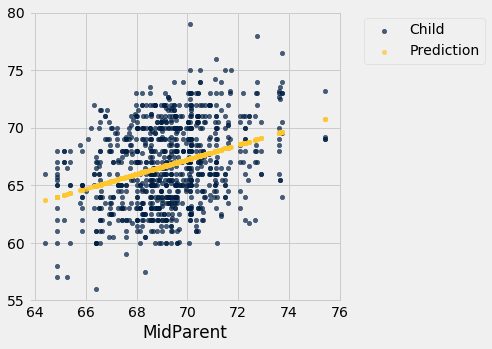

In [37]:
plot_predictions(heights, 'MidParent', 'Child')

In [38]:
def random_r(r):
    "Generate a table of random values with correlation approximately r"
    x = np.random.normal(0, 1, 1000)
    z = np.random.normal(0, 1, 1000)
    y = r*x + (np.sqrt(1-r**2))*z
    return Table().with_columns('x', x, 'y', y)

r          : 0.35987803150587616
RMSE       : 0.8812652820142542
RMSE/std(y): 0.8704878024394556


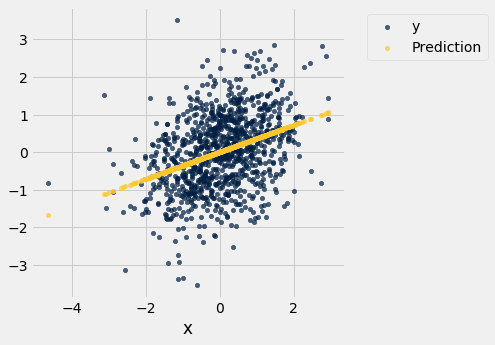

In [39]:
plot_predictions(random_r(correlation(heights, 'MidParent', 'Child')), 'x', 'y')

r          : 0.7560369689141728
RMSE       : 5.8580417921668095
RMSE/std(y): 0.42840810163507004


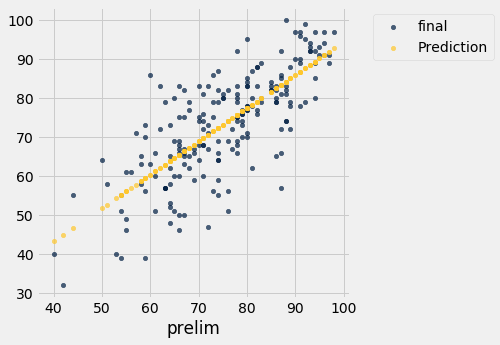

In [40]:
exams = Table.read_table('exams.csv')
plot_predictions(exams, 'prelim', 'final')

r          : 0.7598156762951706
RMSE       : 0.42875271041257146
RMSE/std(y): 0.4226801380561126


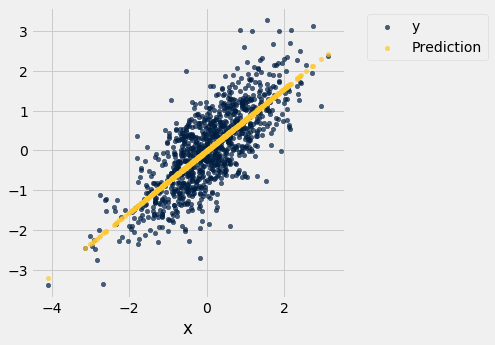

In [41]:
plot_predictions(random_r(correlation(exams, 'prelim', 'final')), 'x', 'y')

r          : 0.9989738874373001
RMSE       : 0.0020085364143648957
RMSE/std(y): 0.002051172218408448


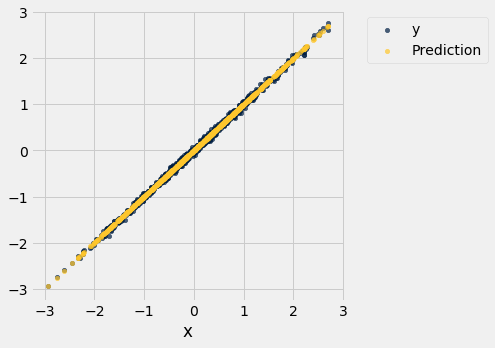

In [42]:
plot_predictions(random_r(.999), 'x', 'y')

r          : 0.5078471667286218
RMSE       : 0.7434257504317601
RMSE/std(y): 0.7420912552457113


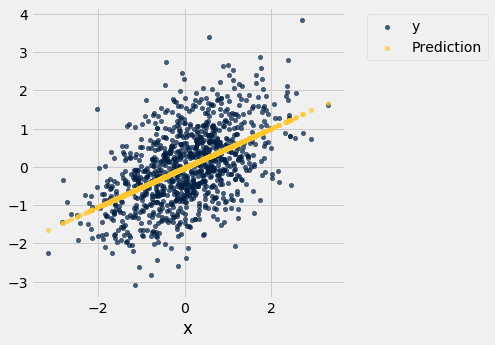

In [43]:
plot_predictions(random_r(.5), 'x', 'y')

r          : 0.03104854573415248
RMSE       : 1.0024311922229279
RMSE/std(y): 0.9990359878077942


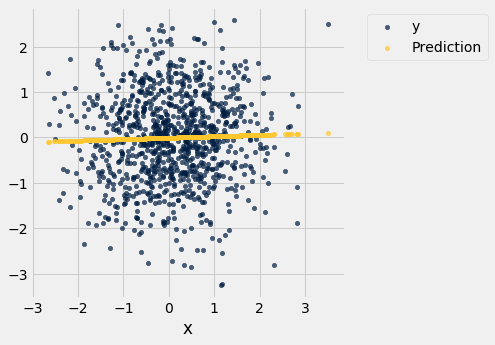

In [44]:
plot_predictions(random_r(0), 'x', 'y')

## Bounds

r          : 0.32094989606395924
RMSE       : 3.208837528548249
RMSE/std(y): 0.8969911642165338


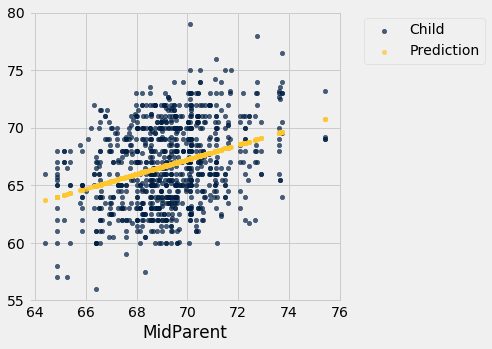

In [45]:
plot_predictions(heights, 'MidParent', 'Child')

In [46]:
heights

MidParent,Child,Prediction,Residual
75.43,73.2,70.7124,2.48763
75.43,69.2,70.7124,-1.51237
75.43,69,70.7124,-1.71237
75.43,69,70.7124,-1.71237
73.66,73.5,69.5842,3.91576
73.66,72.5,69.5842,2.91576
73.66,65.5,69.5842,-4.08424
73.66,65.5,69.5842,-4.08424
72.06,71,68.5645,2.43553
72.06,68,68.5645,-0.564467


In [47]:
rmse_heights = rmse(heights, 'MidParent', 'Child')
heights = heights.with_column(
    'Residual / RMSE', heights.column('Residual') / rmse_heights
)
heights

MidParent,Child,Prediction,Residual,Residual / RMSE
75.43,73.2,70.7124,2.48763,0.775242
75.43,69.2,70.7124,-1.51237,-0.471315
75.43,69,70.7124,-1.71237,-0.533643
75.43,69,70.7124,-1.71237,-0.533643
73.66,73.5,69.5842,3.91576,1.2203
73.66,72.5,69.5842,2.91576,0.908664
73.66,65.5,69.5842,-4.08424,-1.27281
73.66,65.5,69.5842,-4.08424,-1.27281
72.06,71,68.5645,2.43553,0.759008
72.06,68,68.5645,-0.564467,-0.17591


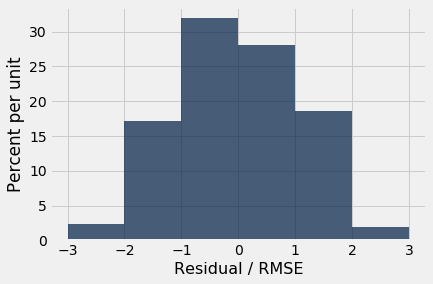

In [48]:
heights.hist('Residual / RMSE', bins=np.arange(-3, 4, 1))

Rule of thumb:
* About 68% of actual y values within 1 RMSE of regression line prediction
* About 95% of actual y values within 2 RMSE of regression line prediction

r          : 0.32094989606395924
RMSE       : 3.208837528548249
RMSE/std(y): 0.8969911642165338


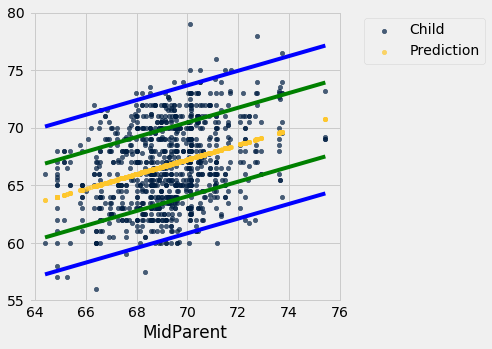

In [49]:
def predict_height(mp):
    return slope(heights, 'MidParent', 'Child') * mp + intercept(heights, 'MidParent', 'Child')

min_x = heights.column('MidParent').min()
max_x = heights.column('MidParent').max()

pred_y_min_x = predict_height(min_x)
pred_y_max_x = predict_height(max_x)

plot_predictions(heights, 'MidParent', 'Child')
plots.plot(make_array(min_x, max_x), make_array(pred_y_min_x, pred_y_max_x)-rmse_heights, color='green');
plots.plot(make_array(min_x, max_x), make_array(pred_y_min_x, pred_y_max_x)+rmse_heights, color='green');
plots.plot(make_array(min_x, max_x), make_array(pred_y_min_x, pred_y_max_x)-2*rmse_heights, color='blue');
plots.plot(make_array(min_x, max_x), make_array(pred_y_min_x, pred_y_max_x)+2*rmse_heights, color='blue');